## Import Fight Data and Merge with Hometown Data

In [21]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

fight_data_file = '../ufcdata/data.csv'
fight_data_file_prep = '../ufcdata/preprocessed_data.csv'
scorecard_data_file = '../scorecard/scorecard.csv'
hometown_data_file = '../elevations/fighters_elevation.csv'

def import_and_merge():
    fight_data = pd.read_csv(fight_data_file)
    hometown_data = pd.read_csv(hometown_data_file)
    
    #Add Blue and Red win columns
    fight_data['B_Winner'] = [1 if x=='Blue' else 0 for x in fight_data['Winner']]
    fight_data['R_Winner'] = [1 if x=='Red' else 0 for x in fight_data['Winner']]
    
    #Drop columns irrelevant to this prediction
    fight_data = fight_data.drop(columns=['Referee', 'no_of_rounds', 'Winner', 'date', 'R_Stance', 'B_Stance'])
    print('Fight Data Stats: ')
    print('Shape: ', fight_data.shape)
    #display(fight_data)
    
    #Separate fight data into individual fighter stats
    blue_fighters = fight_data.loc[:, [col for col in fight_data.columns if re.search('^R_', col)==None]]
    blue_fighters = blue_fighters.rename(columns=lambda x: re.sub('^B_', '', x))
    print('\nBlue fighter Stats: ')
    print('Shape: ', blue_fighters.shape)
    #display(blue_fighters)
    
    red_fighters = fight_data.loc[:, [col for col in fight_data.columns if re.search('^B_', col)==None]]
    red_fighters = red_fighters.rename(columns=lambda x: re.sub('^R_', '', x))
    print('\nRed fighter Stats: ')
    print('Shape: ', red_fighters.shape)
    #display(red_fighters)
    
    #Concatenate blue and red fighter stats
    fighters_data = pd.concat([blue_fighters, red_fighters])
    fighters_data = fighters_data.rename(columns={'total_time_fought(seconds)':'total_time_fought_seconds'})
    print('\nTotal fighter Stats: ')
    print('Shape: ', fighters_data.shape)
    
    # Create df without offence stats
    fighters_no_offence_stats = fighters_data.drop(columns=[col for col in fighters_data.columns if re.search('^avg_', col) != None])
    fighters_no_offence_stats = fighters_data.drop(columns='total_time_fought_seconds')
    print('\nFighters no offensive stats: ')
    print('Shape: ', fighters_data.shape)
    
    #Merge with home town data
    hometown_data['merge_key'] = hometown_data['Fighter Name'].apply(lambda x: ' '.join(sorted(str.lower(x).split())))
    hometown_data = hometown_data[~hometown_data.duplicated('merge_key', keep='first')]
    print('\nHometown Stats: ')
    print('Shape: ', hometown_data.shape)
    
    merged_df = fighters_data.copy()
    merged_df['merge_key'] = merged_df['fighter'].apply(lambda x: ' '.join(sorted(str.lower(x).split())))
    merged_df = pd.merge(left=merged_df, right=hometown_data, how='left', left_on='merge_key', right_on='merge_key')
    merged_df = merged_df.drop(columns=['Fighter Name', 'merge_key'])
    merged_df = merged_df.rename(columns={'Location':'hometown'})
    print('\nFighter + offensive + hometown data stats: ')
    print('Shape: ', merged_df.shape)
    #display(merged_df)

    
    return (fighters_no_offence_stats, fighters_data, merged_df)
    
data_no_offence_stats, data, data_w_hometown,  = import_and_merge()

Fight Data Stats: 
Shape:  (5144, 141)

Blue fighter Stats: 
Shape:  (5144, 72)

Red fighter Stats: 
Shape:  (5144, 72)

Total fighter Stats: 
Shape:  (10288, 72)

Fighters no offensive stats: 
Shape:  (10288, 72)

Hometown Stats: 
Shape:  (1331, 4)

Fighter + offensive + hometown data stats: 
Shape:  (10288, 74)



# Model Selection
- Separate location and home town into city and country
- Categorize weight_class, title_bout, Stance, and locations
- Convert elevation data into numeric data
- Tune parameters
- Visualize model performance

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score


def plot_missing_vals(df):
    columns = []
    nans_per_col = []
    

    for col in df.columns:
        num_nans = sum(pd.isnull(df[col]))
        #print('Num of NaNs in col ', col, ': ', num_nans)
        columns.append(col)
        nans_per_col.append(num_nans)
    
    print('Shape: ', df.shape)
    fig = plt.figure(figsize=(30, 13))
    ax = plt.axes()
    ax.bar(columns, nans_per_col)
    plt.xticks(rotation='vertical')
    plt.ylabel('# NaNs')
    plt.title('Number of missing data per feature')
    
def inspect_data(fighter_df):
    # Display missing value numbers in fighter data
    print('\nBefore dropping fightres with no offence/defence stats')
    #plot_missing_vals(fighter_df)
        
    #Remove rows with a lot of missing information
    if 'avg_BODY_att' in fighter_df.columns:
        fighter_df = fighter_df[~pd.isnull(fighter_df['avg_BODY_att'])]
    elif 'total_time_fought_seconds' in fighter_df.columns:
        fighter_df = fighter_df[~pd.isnull(fighter_df['total_time_fought_seconds'])]       
    print('\nAfter dropping fighters with no offence/defemce stats') 
    #plot_missing_vals(fighter_df)
    
    #Fighter age, weight, height, and reach distribution
    hrw_attrs_df = pd.DataFrame(fighter_df[['Height_cms', 'Reach_cms', 'Weight_lbs']])    
    fig = plt.figure(figsize=(30, 13))
    ax = plt.axes()
    hrw_attrs_df.boxplot()
    plt.title('Height, Reach and weight dsitributions')
    plt.ylim([100, 250])
    
    age_df = pd.DataFrame(fighter_df[['age']])   
    fig = plt.figure(figsize=(30, 13))
    ax = plt.axes()
    age_df.boxplot()
    plt.title('Age dsitributions')
       

def clean_data(fighter_df):    
   #Fill missing values for height, reach, weight, age
    weight_class_means = {}
    weight_classes = np.unique(fighter_df['weight_class'])
    for weight_class in weight_classes:
        weight_class_idx = fighter_df['weight_class'] == weight_class
        
        null_idx = np.logical_and(pd.isnull(fighter_df['Height_cms']), weight_class_idx)
        fighter_df.loc[null_idx, 'Height_cms'] = np.nanmean(fighter_df.loc[weight_class_idx, 'Height_cms'])
        
        null_idx = np.logical_and(pd.isnull(fighter_df['Reach_cms']), weight_class_idx)
        fighter_df.loc[null_idx, 'Reach_cms'] = np.nanmean(fighter_df.loc[weight_class_idx, 'Reach_cms'])
        
        null_idx = np.logical_and(pd.isnull(fighter_df['Weight_lbs']), weight_class_idx)
        fighter_df.loc[null_idx, 'Weight_lbs'] = np.nanmean(fighter_df.loc[weight_class_idx, 'Weight_lbs'])
        
        null_idx = np.logical_and(pd.isnull(fighter_df['age']), weight_class_idx)
        fighter_df.loc[null_idx, 'age'] = np.nanmean(fighter_df.loc[weight_class_idx, 'age'])
    
   #Drop rows with too many missing values
    if 'avg_BODY_att' in fighter_df.columns:
        fighter_df = fighter_df.loc[~pd.isnull(fighter_df['avg_BODY_att']), :]    
        
    return fighter_df

def structure_data(fighter_df):   
    # Split Locations  and hometowns into city and country
    fighter_df['city'] = [str.lower(location.split(', ')[0]) for location in fighter_df['location']]
    fighter_df['country'] = [str.lower(location.split(', ')[-1]) for location in fighter_df['location']]
    fighter_df = fighter_df.drop(columns='location')
    
    if 'hometown' in fighter_df.columns:
        #First get rid of data with nan hometowns
        fighter_df['hometown_city'] = [str.lower(location.split(', ')[0]) for location in fighter_df['hometown']]
        fighter_df['hometown_country'] = [str.lower(location.split(', ')[-1]) for location in fighter_df['hometown']]
        fighter_df.drop(columns='hometown')
        
    return fighter_df
    

def compare_models(knn_params, lr_params, svc_params, nbayes_params, rforest_params, features, labels): # Receives already scales
    accuracy_df = pd.DataFrame(columns=['KNN', 'Logistic Regression', 'SVC', 'Naive Bayes', 'Random Forest'])
    precision_df = pd.DataFrame(columns=['KNN', 'Logistic Regression', 'SVC', 'Naive Bayes', 'Random Forest'])
    recall_df = pd.DataFrame(columns=['KNN', 'Logistic Regression', 'SVC', 'Naive Bayes', 'Random Forest'])
    f1_df = pd.DataFrame(columns=['KNN', 'Logistic Regression', 'SVC', 'Naive Bayes', 'Random Forest'])
    
    idx = 0;
    for seed in range(1, 20):
        X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(features, labels, train_size=0.75, test_size=0.25, random_state=seed, stratify=labels)
        
        #Models
        knn = KNeighborsClassifier(**knn_params).fit(X_train_scaled, y_train)    
        lr = LogisticRegression(**lr_params).fit(X_train_scaled, y_train)  
        svc = LinearSVC(**svc_params).fit(X_train_scaled, y_train)
        n_bayes = BernoulliNB(**nbayes_params).fit(X_train_scaled, y_train)
        random_forest = RandomForestClassifier(**rforest_params).fit(X_train_scaled, y_train)
        
        #Update tables
        accuracy_df.loc[idx] = [knn.score(X_test_scaled, y_test), lr.score(X_test_scaled, y_test), svc.score(X_test_scaled, y_test), 
                                n_bayes.score(X_test_scaled, y_test), random_forest.score(X_test_scaled, y_test)]

        precision_df.loc[idx] = [precision_score(y_test, knn.predict(X_test_scaled)), precision_score(y_test, lr.predict(X_test_scaled)), 
                                 precision_score(y_test, svc.predict(X_test_scaled)), precision_score(y_test, n_bayes.predict(X_test_scaled)),
                                 precision_score(y_test, random_forest.predict(X_test_scaled))]

        recall_df.loc[idx] = [recall_score(y_test, knn.predict(X_test_scaled)), recall_score(y_test, lr.predict(X_test_scaled)), 
                              recall_score(y_test, svc.predict(X_test_scaled)), recall_score(y_test, n_bayes.predict(X_test_scaled)),
                              recall_score(y_test, random_forest.predict(X_test_scaled))]

        f1_df.loc[idx] = [f1_score(y_test, knn.predict(X_test_scaled)), f1_score(y_test, lr.predict(X_test_scaled)), 
                          f1_score(y_test, svc.predict(X_test_scaled)), f1_score(y_test, n_bayes.predict(X_test_scaled)),
                          f1_score(y_test, random_forest.predict(X_test_scaled))]
        idx += 1
        
    #Display results
    display(accuracy_df)
    display(precision_df)
    display(recall_df)
    display(f1_df)
    
    fig = plt.figure(figsize=(15, 7))
    accuracy_df.boxplot()
    plt.title('Accuracy scores')
    
    fig = plt.figure(figsize=(15, 7))       
    precision_df.boxplot()
    plt.title('Precision score')
    
    fig = plt.figure(figsize=(15, 7))        
    recall_df.boxplot()
    plt.title('Recall score')

    fig = plt.figure(figsize=(15, 7))        
    f1_df.boxplot()
    plt.title('F1 score')
    
    
def parameter_tuning(df, scale):
    #inspect_data(df.copy())
    df = structure_data(df)
    df = clean_data(df)
    df = df.drop(columns=['fighter'])
    dummy_df = pd.get_dummies(df)
    
    labels = dummy_df['Winner']
    features = dummy_df.drop(columns=['Winner'])
    X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.75, test_size=0.25, random_state=0, stratify=labels)
    
    #Scale
    if scale:
        scaler = StandardScaler().fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    else:
        X_train_scaled = X_train
        X_test_scaled = X_test

    
    # Search for best parameters
    knn = KNeighborsClassifier().fit(X_train_scaled, y_train)
    knn_tuner = GridSearchCV(knn, param_grid={'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'], 'n_neighbors':list(range(1,51))}).fit(X_train_scaled, y_train)
    print('KNN Best params:', knn_tuner.best_params_ )
    
    lr = LogisticRegression().fit(X_train_scaled, y_train)
    lr_tuner =  GridSearchCV(lr, param_grid={'solver':['newton-cg', 'lbfgs', 'liblinear'], 'C':list(np.linspace(0.001,20,40))}).fit(X_train_scaled, y_train)
    print('LR Best params:', lr_tuner.best_params_)
    
    svc = LinearSVC().fit(X_train_scaled, y_train)
    svc_tuner = GridSearchCV(svc, param_grid={'C':list(np.linspace(0.0000000001, 0.15, 50))}).fit(X_train_scaled, y_train)
    print('SVC Best params:', svc_tuner.best_params_)
    
    n_bayes = BernoulliNB().fit(X_train_scaled, y_train)
    nbayes_tuner = GridSearchCV(n_bayes, param_grid={'alpha':list(np.linspace(0.0000000001, 21, 50))}).fit(X_train_scaled, y_train)
    print('NaiveBayes Best params:', nbayes_tuner.best_params_)
    
    random_forest = RandomForestClassifier(n_estimators=100, random_state=0).fit(X_train_scaled, y_train)
    rforest_tuner = GridSearchCV(random_forest, param_grid={'max_features':['auto', 'sqrt', 'log2'], 'max_depth':list(np.linspace(1,30,50)), 'min_samples_split':list(range(2,30))}).fit(X_train_scaled, y_train)
    print('RandomForest Best params:', rforest_tuner.best_params_)
    
    # Compare models with tuned parameters
    compare_models( knn_tuner.best_params_, lr_tuner.best_params_, svc_tuner.best_params_, nbayes_tuner.best_params_, rforest_tuner.best_params_, features, labels)
    return(knn_tuner.best_params_, lr_tuner.best_params_, svc_tuner.best_params_, nbayes_tuner.best_params_, rforest_tuner.best_params_, features, labels)
    


In [ ]:
# Compare models for Data with no offensive stats
knn_params, lr_params, svc_params, nbayes_params, rforest_params, features, labels = parameter_tuning(data_no_offence_stats, alse)

In [ ]:
# Compare models for data with offensive stats
knn_params_offence, lr_params_offence, svc_params_offence, nbayes_params_offence, rforest_params_offence, features_offence, labels_offence = parameter_tuning(data, False)

,KNN,Logistic Regression,SVC,Naive Bayes,Random Forest
0,0.530564,0.572111,0.505253,0.514327,0.558262
1,0.535339,0.574976,0.509551,0.506208,0.541070
2,0.519102,0.559694,0.504776,0.504776,0.535339
3,0.532474,0.565425,0.504298,0.512416,0.528653
4,0.521012,0.565425,0.500478,0.487584,0.526743
5,0.527221,0.568768,0.515759,0.507641,0.540592
6,0.528176,0.558739,0.495702,0.500000,0.525310
7,0.511939,0.573543,0.505253,0.514804,0.531996
8,0.539160,0.562082,0.514327,0.507163,0.542502


,KNN,Logistic Regression,SVC,Naive Bayes,Random Forest
0,0.534184,0.575701,0.505253,0.514823,0.559534
1,0.536924,0.578652,0.507470,0.509585,0.545285
2,0.524079,0.561483,0.505017,0.508714,0.540592
3,0.535363,0.569811,0.777778,0.514907,0.532962
4,0.524229,0.566427,0.611111,0.494631,0.530876
5,0.530853,0.570647,0.511089,0.510949,0.544444
6,0.534113,0.561808,0.550000,0.504355,0.531496
7,0.517341,0.575342,0.505268,0.515373,0.534698
8,0.541260,0.565460,0.510133,0.509448,0.544248


,KNN,Logistic Regression,SVC,Naive Bayes,Random Forest
0,0.553875,0.582231,1.000000,0.672968,0.590737
1,0.584121,0.584121,0.995274,0.603025,0.551985
2,0.524575,0.586957,0.999055,0.579395,0.534972
3,0.565217,0.570888,0.026465,0.603970,0.542533
4,0.562382,0.596408,0.031191,0.653119,0.544423
5,0.552930,0.591682,0.958412,0.595463,0.555766
6,0.517958,0.575614,0.010397,0.602079,0.510397
7,0.507561,0.595463,0.997164,0.665406,0.568053
8,0.576560,0.575614,0.975425,0.662571,0.581285


,KNN,Logistic Regression,SVC,Naive Bayes,Random Forest
0,0.543852,0.578947,0.671320,0.583367,0.574713
1,0.559529,0.581373,0.672199,0.552381,0.548614
2,0.524327,0.573937,0.670898,0.541759,0.537767
3,0.549885,0.570349,0.051188,0.555894,0.537705
4,0.542636,0.581031,0.059353,0.562933,0.537564
5,0.541667,0.580974,0.666667,0.549978,0.550047
6,0.525912,0.568627,0.020408,0.548901,0.520733
7,0.512405,0.585230,0.670693,0.580858,0.550871
8,0.558352,0.570492,0.669912,0.576007,0.562157


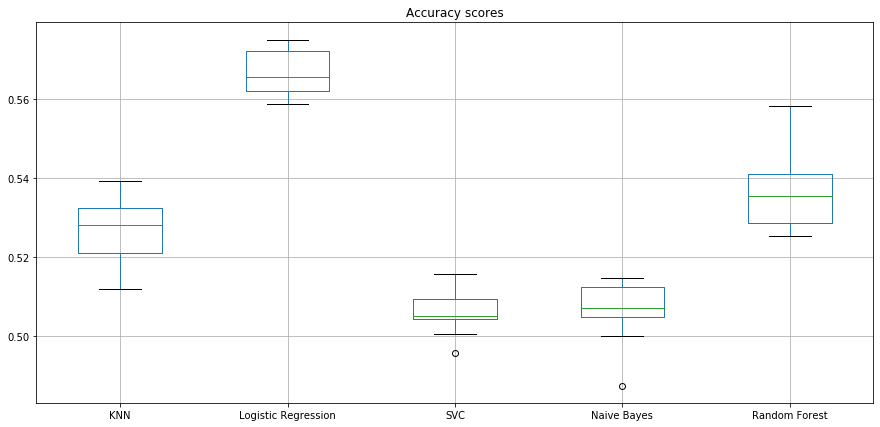

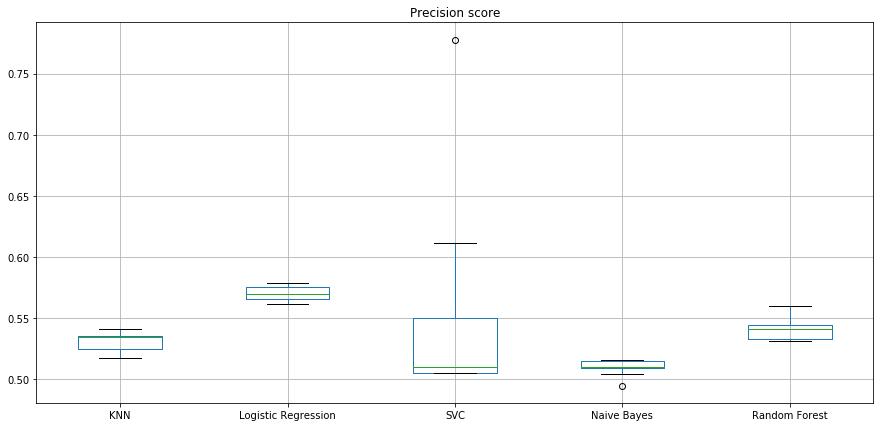

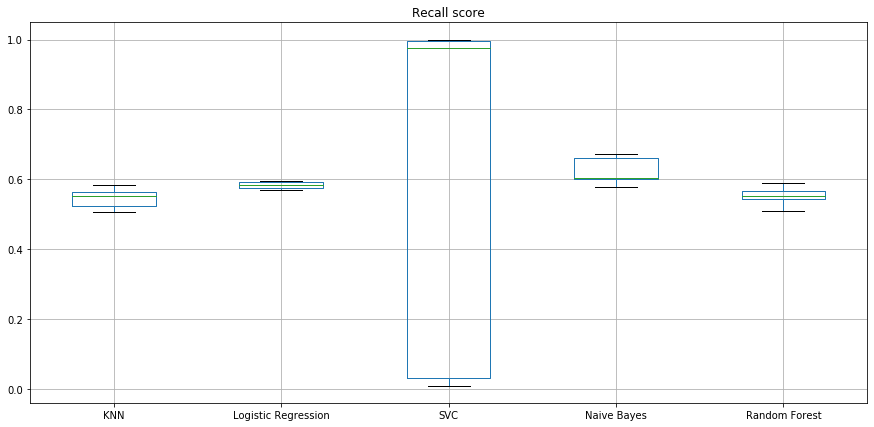

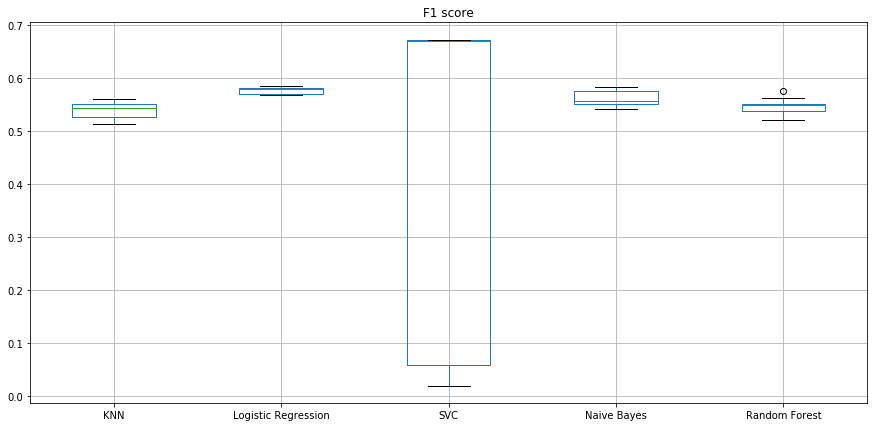

In [23]:
# Tuned Parameters for unsclaed data. Data with no offensive stats
# knn_params =  {'algorithm': 'auto', 'n_neighbors': 19}
# lr_params = {'C': 0.001, 'solver': 'newton-cg'}
# svc_params = {'C': 0.11326530614693876}
# nbayes_params =  {'alpha': 12.428571428612246}
# rforest_params = {'max_depth': 7.5102040816326525, 'max_features': 'auto', 'min_samples_split': 4}
# df = structure_data(data_no_offence_stats.copy())
# df = clean_data(df)
# df = df.drop(columns=['fighter'])
# dummy_df = pd.get_dummies(df)

# labels = dummy_df['Winner']
# features = dummy_df.drop(columns=['Winner'])
# compare_models(knn_params, lr_params, svc_params, nbayes_params, rforest_params, features, labels)

In [ ]:
# Explore correlation and find best correlated features

In [ ]:
# See if models improve with best parameters

In [ ]:
# Seek to improve logistic Regression with feature selection